In [118]:
from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot
from matplotlib import pyplot
from mlxtend.feature_selection import SequentialFeatureSelector as sfbs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfbs
from numpy import *
from numpy import absolute
from numpy import arange
from numpy import mean
from numpy import std
from numpy.random import seed
from pandas import read_csv
from random import randint
from random import random
from random import seed
from scipy import stats # For in-built method to get PCC
from sklearn import linear_model
from sklearn.datasets import load_boston
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, RepeatedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import OLSInfluence
from tqdm import tnrange, tqdm_notebook
from zca import zca
import itertools
import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import pandas as pd
import pingouin as pg
import scipy
import seaborn as sns
import sklearn.linear_model
import statsmodels.api as sm
import statsmodels.tools
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
#import random

y_train_scaler = StandardScaler()
x_train_inter_scaler = StandardScaler()
zca = zca.ZCA()

In [81]:
numCV = 2
kfold = KFold(n_splits=numCV, shuffle=True)
p_threshold = .05
target = 'Poverty'
exclude = 'States'

cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)

alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
l1s = arange(0, 1, 0.05)

seed_ = 3

#random.seed(11)

seed(seed_)

In [3]:
# evaluate a model
def evaluate_model(X, y, model):
	# define model evaluation method
	cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	# force scores to be positive
	return absolute(scores)

# plot the dataset and the model's line of best fit
def plot_best_fit(X, y, model):
	# fut the model on all data
	model.fit(X, y)
	# plot the dataset
	pyplot.scatter(X, y)
	# plot the line of best fit
	xaxis = arange(X.min(), X.max(), 0.01)
	yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))
	pyplot.plot(xaxis, yaxis, color='r')
	# show the plot
	pyplot.title(type(model).__name__)
	pyplot.show()

In [4]:
all_data = pd.read_csv('../data/raw/states.csv')

In [119]:

train, valid = train_test_split(all_data.index, test_size=0.3, shuffle=True)
valid, test = train_test_split(valid,  test_size=0.5, shuffle=True)

X = all_data[set(all_data.columns).difference([target,exclude])].copy()
y = pd.DataFrame(all_data[target].copy())

X_train = X.loc[train].copy()
X_valid = X.loc[valid].copy()
X_test = X.loc[test].copy()

y_train = y.loc[X_train.index][target].copy()
y_valid = y.loc[X_valid.index][target].copy()
y_test = y.loc[X_test.index][target].copy()

y_train_scaler.fit(np.array(y_train).reshape(-1, 1))
y_train_scaled = pd.DataFrame(y_train_scaler.transform(np.array(y_train).reshape(-1, 1)))
y_train_scaled.index = y_train.index
y_train_scaled.columns = [target]
#pd.DataFrame([i[0] for i in scaler.transform(np.array(y_train).reshape(-1, 1))])

In [124]:
import sklearn
from sklearn.preprocessing import *

interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)


X_inter = pd.DataFrame(interaction.fit_transform(X), columns=interaction.get_feature_names(input_features=X_train.columns))
X_inter.index = X.index
X_train_inter = X_inter.loc[X_train.index]

x_train_inter_scaler.fit(X_train_inter)
x_train_inter_scaled = pd.DataFrame(x_train_inter_scaler.transform(np.array(X_train_inter)))
x_train_inter_scaled.index = X_train.index
x_train_inter_scaled.columns = X_train_inter.columns

In [93]:
lr = LinearRegression()

#backwards step subset
sfbs1 = sfbs(lr, 
          k_features=len(x_train_inter_scaled.columns), 
          #forward=True, 
          floating=True, 
          scoring='neg_mean_squared_error',
          #scoring='accuracy',
          n_jobs=-1,
          cv=numCV)
            
sfbs1 = sfbs1.fit(x_train_inter_scaled, y_train_scaled)


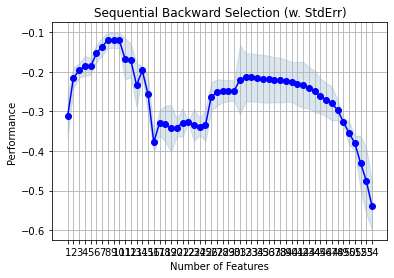

In [94]:
fig = plot_sfbs(sfbs1.get_metric_dict(), kind='std_err')

plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.show()

In [95]:
features = list(pd.DataFrame(sfbs1.subsets_).loc['feature_names'].values)

In [96]:
ss_position = np.array(pd.DataFrame(pd.DataFrame(sfbs1.subsets_)).loc['avg_score']).argmax()

In [97]:
pd.DataFrame(sfbs1.subsets_).T[['avg_score','feature_names']]

,avg_score,feature_names
1,-0.311487,"(Income White,)"
2,-0.215227,"(Income White, Infant Mort Crime)"
3,-0.196549,"(Income White, Traf Deaths Unemployed, Infant ..."
4,-0.184974,"(Income White, White University, Traf Deaths U..."
5,-0.18635,"(Income White, White University, Traf Deaths U..."
6,-0.153339,"(Traf Deaths, Income White, White University, ..."
7,-0.135949,"(Traf Deaths, Income White, White Infant Mort,..."
8,-0.119761,"(Traf Deaths, Income White, White Infant Mort,..."
9,-0.12003,"(Traf Deaths, Income White, White Doctors, Whi..."
10,-0.120611,"(Traf Deaths, Income White, White Doctors, Whi..."


In [98]:
ss_sortedFeatures = list(np.array(pd.DataFrame(sfbs1.subsets_).loc['feature_names'])[ss_position])

In [99]:
print(ss_sortedFeatures)

['Traf Deaths', 'Income White', 'White Infant Mort', 'White University', 'Traf Deaths Population', 'Traf Deaths University', 'Traf Deaths Unemployed', 'Infant Mort Crime']


In [101]:
CV_results = pd.DataFrame()#[]#np.zeros(shape=(len(features),5))

#looping over sequentially selected features, deriving ElasticNet hyper parm's over each best subset and noting error

for f in features:

    print(f)
    cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)

    EN_CV = ElasticNetCV(l1_ratio=l1s, alphas=alphas, cv=cv, n_jobs=-1)
    # fit model

    X_subset = pd.DataFrame(x_train_inter_scaled[list(np.asarray(f))])
    y_ = y_train_scaled
    EN_CV.fit(X_subset, y_)
    
    print('alpha: %f' % EN_CV.alpha_)
    print('l1_ratio_: %f' % EN_CV.l1_ratio_)
    
    # evaluate model
    scores = cross_val_score(EN_CV, X_subset, y_, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # force scores to be positive
    scores = absolute(scores)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    
    temp = pd.concat([pd.DataFrame({"features": [np.array(f)]}),pd.DataFrame(np.array(mean(scores)).reshape(-1,1)),pd.DataFrame(np.array(std(scores)).reshape(-1,1)),pd.DataFrame(np.array(EN_CV.alpha_).reshape(-1,1)),pd.DataFrame(np.array(EN_CV.l1_ratio_).reshape(-1,1))],axis=1)
    
    CV_results = pd.concat([CV_results,temp],axis=0)

('Income White',)
alpha: 0.000000
l1_ratio_: 0.000000
Mean MAE: 0.400 (0.029)
('Income White', 'Infant Mort Crime')
alpha: 0.000000
l1_ratio_: 0.000000
Mean MAE: 0.344 (0.005)
('Income White', 'Traf Deaths Unemployed', 'Infant Mort Crime')
alpha: 0.001000
l1_ratio_: 0.000000
Mean MAE: 0.386 (0.069)
('Income White', 'White University', 'Traf Deaths Unemployed', 'Infant Mort Crime')
alpha: 0.010000
l1_ratio_: 0.000000
Mean MAE: 0.389 (0.066)
('Income White', 'White University', 'Traf Deaths University', 'Traf Deaths Unemployed', 'Infant Mort Crime')
alpha: 0.010000
l1_ratio_: 0.000000
Mean MAE: 0.393 (0.062)
('Traf Deaths', 'Income White', 'White University', 'Traf Deaths University', 'Traf Deaths Unemployed', 'Infant Mort Crime')
alpha: 0.010000
l1_ratio_: 0.000000
Mean MAE: 0.394 (0.061)
('Traf Deaths', 'Income White', 'White Infant Mort', 'White University', 'Traf Deaths University', 'Traf Deaths Unemployed', 'Infant Mort Crime')
alpha: 0.010000
l1_ratio_: 0.000000
Mean MAE: 0.397 (0.

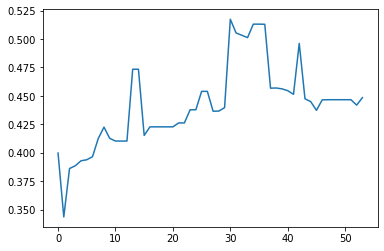

['Income White' 'Infant Mort Crime']
['Income White' 'Infant Mort Crime']


,features,mean error,std,alpha,lambda
0,[Income White],0.399777,0.028522,0.000,0.00
1,"[Income White, Infant Mort Crime]",0.343643,0.004804,0.000,0.00
2,"[Income White, Traf Deaths Unemployed, Infant ...",0.386183,0.068861,0.001,0.00
3,"[Income White, White University, Traf Deaths U...",0.388605,0.066439,0.010,0.00
4,"[Income White, White University, Traf Deaths U...",0.392986,0.062058,0.010,0.00
5,"[Traf Deaths, Income White, White University, ...",0.393889,0.061155,0.010,0.00
6,"[Traf Deaths, Income White, White Infant Mort,...",0.396583,0.063849,0.010,0.00
7,"[Traf Deaths, Income White, White Infant Mort,...",0.412541,0.047891,0.001,0.95
8,"[Traf Deaths, Income White, White Doctors, Whi...",0.422555,0.035541,0.000,0.40
9,"[Traf Deaths, Income White, White Doctors, Whi...",0.412682,0.045414,0.001,0.95


In [102]:
CV_results.columns = ['features','mean error','std','alpha','lambda']
CV_results.index = np.array(range(0,len(features)))#range(1,len(features)+1)
plt.plot(CV_results['mean error'])
plt.show()

best = CV_results.iloc[CV_results['mean error'].idxmin()]
print(best.loc['features'])

parse = CV_results[CV_results['mean error']<=(np.min(CV_results['mean error'])+np.std(CV_results['mean error']))].iloc[0]
print(parse.loc['features'])
display(CV_results)

In [103]:
ss_sortedFeatures

['Traf Deaths',
 'Income White',
 'White Infant Mort',
 'White University',
 'Traf Deaths Population',
 'Traf Deaths University',
 'Traf Deaths Unemployed',
 'Infant Mort Crime']

In [104]:
model_ss = LinearRegression()
model_ep = ElasticNet(alpha=parse['alpha'], l1_ratio=parse['lambda'])
model_eb = ElasticNet(alpha=best['alpha'], l1_ratio=best['lambda'])

model_ss.fit(x_train_inter_scaled[ss_sortedFeatures], y_train_scaled)
model_ep.fit(x_train_inter_scaled[parse['features']],y_train_scaled)
model_eb.fit(x_train_inter_scaled[best['features']],y_train_scaled)

ElasticNet(alpha=0.0, l1_ratio=0.0)

In [105]:
zca_X_train = pd.DataFrame(zca.fit_transform(x_train_inter_scaled[ss_sortedFeatures]),columns=ss_sortedFeatures)
zca_X_train.index = x_train_inter_scaled.index
zca_data = pd.concat([y_train_scaled,x_train_inter_scaled],axis=1)
zca_data.index = x_train_inter_scaled.index

In [106]:
zca_data.pcorr()

,Poverty,Income,White,Doctors,Traf Deaths,Population,Infant Mort,Crime,University,Unemployed,...,Infant Mort^2,Infant Mort Crime,Infant Mort University,Infant Mort Unemployed,Crime^2,Crime University,Crime Unemployed,University^2,University Unemployed,Unemployed^2
Poverty,1.000000,-0.408736,0.329072,-0.165225,-0.029375,-0.304332,0.554106,-0.267780,0.266711,-0.456614,...,-0.264353,-0.189401,-0.228811,0.018477,0.344721,-0.513706,-0.234483,0.177425,0.387336,0.048472
Income,-0.408736,1.000000,-0.202672,-0.381817,0.468263,-0.383293,0.794752,0.560699,-0.579226,-0.202477,...,-0.505928,0.123046,-0.334431,0.366403,-0.199479,-0.741734,-0.131149,0.591157,0.359316,0.243783
White,0.329072,-0.202672,1.000000,0.602456,0.812263,0.625786,-0.173340,0.800678,-0.827126,0.867335,...,0.178334,0.146914,0.545035,0.202568,-0.442219,0.295650,0.184975,0.368440,-0.689264,-0.115992
Doctors,-0.165225,-0.381817,0.602456,1.000000,-0.422514,-0.956854,0.472887,-0.168813,0.174857,-0.826838,...,-0.316703,-0.115095,-0.804129,-0.054930,0.114720,-0.621159,-0.138270,0.155176,0.719596,0.493714
Traf Deaths,-0.029375,0.468263,0.812263,-0.422514,1.000000,-0.376284,-0.047782,-0.669590,0.847644,-0.652958,...,-0.247269,-0.060347,-0.559471,-0.117884,0.234956,-0.122788,-0.178199,-0.535254,0.587287,0.215254
Population,-0.304332,-0.383293,0.625786,-0.956854,-0.376284,1.000000,0.494659,-0.267199,0.234451,-0.862134,...,-0.234667,-0.299497,-0.766261,-0.127210,0.225830,-0.616607,-0.069948,0.197386,0.689311,0.395471
Infant Mort,0.554106,0.794752,-0.173340,0.472887,-0.047782,0.494659,1.000000,-0.242279,0.125376,0.557964,...,0.785619,-0.294979,0.527297,-0.470777,0.221680,0.871118,0.264594,-0.281838,-0.518388,-0.333270
Crime,-0.267780,0.560699,0.800678,-0.168813,-0.669590,-0.267199,-0.242279,1.000000,0.921845,-0.530227,...,0.305076,-0.380731,-0.109410,-0.550515,0.708917,0.096791,0.092859,-0.416411,0.279987,-0.103855
University,0.266711,-0.579226,-0.827126,0.174857,0.847644,0.234451,0.125376,0.921845,1.000000,0.588913,...,-0.015108,0.211076,0.257208,0.339057,-0.497309,-0.001543,0.053015,0.511971,-0.374213,-0.016786
Unemployed,-0.456614,-0.202477,0.867335,-0.826838,-0.652958,-0.862134,0.557964,-0.530227,0.588913,1.000000,...,-0.432198,-0.122958,-0.766863,-0.043801,0.271587,-0.656856,-0.137311,-0.088312,0.802462,0.333014


In [ ]:
#sns.pairplot(zca_data,kind="reg", plot_kws={'line_kws':{'color':'red'}})

In [108]:
#model = sklearn.linear_model.LinearRegression()
data_set_wConstant = statsmodels.tools.tools.add_constant(zca_data)
#y_ = data_set_wConstant[target]
X_trainwConstant = data_set_wConstant[data_set_wConstant.columns.drop(target)]
#results = model.fit(X, y)
model = sm.OLS(y_train_scaled,X_trainwConstant)
results = model.fit()
fitted = results.predict(X_trainwConstant)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Poverty   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 18 Aug 2021   Prob (F-statistic):                nan
Time:                        20:35:28   Log-Likelihood:                 1102.3
No. Observations:                  35   AIC:                            -2135.
Df Residuals:                       0   BIC:                            -2080.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.1256        inf          0        nan         nan         nan
Income                     -1.2027        inf         -0        nan         nan         nan
White                      -0.4785        inf         -0        nan         nan         nan
Doctors                    -1.9018        inf         -0        nan         nan         nan
Traf Deaths                 0.8962        inf          0        nan         nan         nan
Population                  1.6019        inf          0        nan         nan         nan
Infant Mort                -1.0849        inf         -0        nan         nan         nan
Crime                       1.7685        inf          0        nan         nan         nan
University                 -0.9943        inf         -0        nan         nan         nan
Unemployed                 -0.4164        inf         -0        nan         nan         nan
Income^2                   -2.0850        inf         -0        nan         nan         nan
Income White                1.9450        inf          0        nan         nan         nan
Income Doctors              0.5847        inf          0        nan         nan         nan
Income Traf Deaths         -0.5771        inf         -0        nan         nan         nan
Income Population           0.5679        inf          0        nan         nan         nan
Income Infant Mort          0.3978        inf          0        nan         nan         nan
Income Crime               -0.6499        inf         -0        nan         nan         nan
Income University           0.4334        inf          0        nan         nan         nan
Income Unemployed           0.5849        inf          0        nan         nan         nan
White^2                    -1.5015        inf         -0        nan         nan         nan
White Doctors              -0.5747        inf         -0        nan         nan         nan
White Traf Deaths           1.4030        inf          0        nan         nan         nan
White Population            1.7365        inf          0        nan         nan         nan
White Infant Mort           0.2997        inf          0        nan         nan         nan
White Crime                 0.1969        inf          0        nan         nan         nan
White University            0.3962        inf          0        nan         nan         nan
White Unemployed           -1.1661        inf         -0        nan         nan         nan
Doctors^2                   2.1652        inf          0        nan         nan         nan
Doctors Traf Deaths         2.2304        inf          0        nan         nan         nan
Doctors Population         -1.9460        inf         -0        nan         nan         nan
Doctors Infant Mort        -0.3413        inf  

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

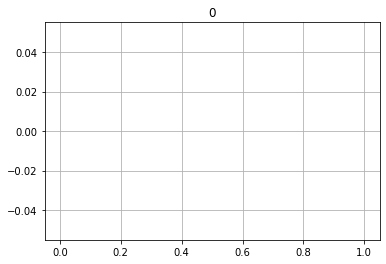

In [109]:
pd.DataFrame(results.get_influence().resid_studentized_internal).hist()

Summary of Regression
:                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 18 Aug 2021   Prob (F-statistic):                nan
Time:                        20:35:40   Log-Likelihood:                 1102.3
No. Observations:                  35   AIC:                            -2135.
Df Residuals:                       0   BIC:                            -2080.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1256        

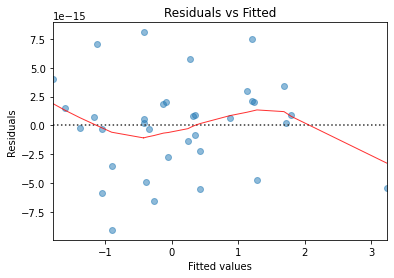

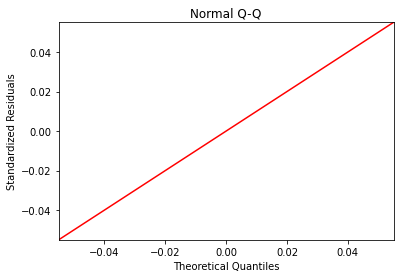

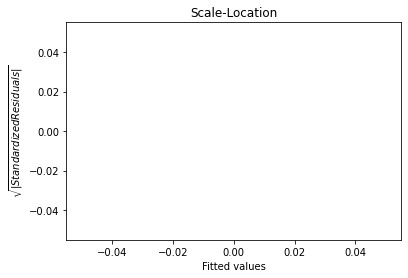

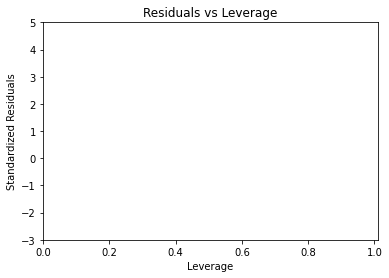

In [110]:
linear_plot = Plot.LinearRegressionResidualPlot(X_trainwConstant.values, y_train_scaled.values)
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))


[1.]
[-4.20362751e-14]


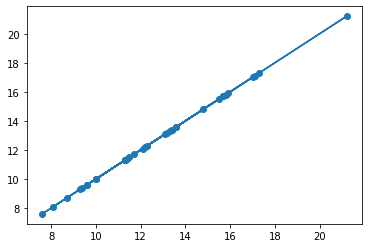

In [111]:
plt.scatter(results.fittedvalues*scaler.scale_[0] + scaler.mean_[0], y_train_scaled*scaler.scale_[0] + scaler.mean_[0])

m, b = np.polyfit(results.fittedvalues*scaler.scale_[0] + scaler.mean_[0], y_train_scaled*scaler.scale_[0] + scaler.mean_[0], 1)
plt.plot(results.fittedvalues*scaler.scale_[0] + scaler.mean_[0], m*results.fittedvalues*scaler.scale_[0] + scaler.mean_[0] + b)
print(m)
print(b)

12.431428571428572

Mean Absolute Error
Poverty    0.90475
dtype: float64


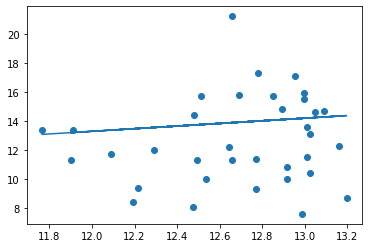

In [120]:
#model_Best = ElasticNet(alpha=best['alpha'], l1_ratio=best['lambda'])

ENBestResults = model_eb.fit(x_train_inter_scaled[best['features']], y_train_scaled)
ENBestFitted = ENBestResults.predict(x_train_inter_scaled[best['features']])

yhat = pd.DataFrame(model_eb.predict(x_train_inter_scaled[best['features']]))
yhat.index = x_train_inter_scaled.index
yhat.columns = ['Poverty']

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(yhat-pd.DataFrame(y_train_scaled))))

plt.scatter(ENBestFitted*y_train_scaler.scale_[0] + y_train_scaler.mean_[0],y_train_scaled*y_train_scaler.scale_[0] + y_train_scaler.mean_[0])
m, b = np.polyfit(ENBestFitted*y_train_scaler.scale_[0] + y_train_scaler.mean_[0], y_train_scaled*scaler.scale_[0] + y_train_scaler.mean_[0], 1)
plt.plot(ENBestFitted*y_train_scaler.scale_[0] + y_train_scaler.mean_[0], m*ENBestFitted*y_train_scaler.scale_[0] + y_train_scaler.mean_[0] + b)

StandardScaler()

Mean Absolute Error
Poverty    0.90475
dtype: float64


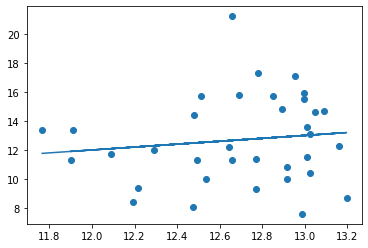

In [121]:
#model_Parse = ElasticNet(alpha=parse['alpha'], l1_ratio=parse['lambda'])

ENParseResults = model_ep.fit(x_train_inter_scaled[parse['features']], y_train_scaled)
ENParseFitted = ENParseResults.predict(x_train_inter_scaled[parse['features']])

yhat = pd.DataFrame(model_ep.predict(x_train_inter_scaled[parse['features']]))
yhat.index = x_train_inter_scaled.index
yhat.columns = ['Poverty']

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(yhat-pd.DataFrame(y_train_scaled))))

plt.scatter(ENParseFitted*y_train_scaler.scale_[0] + y_train_scaler.mean_[0],y_train_scaled*y_train_scaler.scale_[0] + y_train_scaler.mean_[0])
m, b = np.polyfit(ENParseFitted*y_train_scaler.scale_[0] + y_train_scaler.mean_[0], y_train_scaled*y_train_scaler.scale_[0] + y_train_scaler.mean_[0], 1)
plt.plot(ENParseFitted*y_train_scaler.scale_[0] + y_train_scaler.mean_[0], m*ENParseFitted*y_train_scaler.scale_[0] + y_train_scaler.mean_[0] + b)

Mean MAE: 0.472 (0.045)


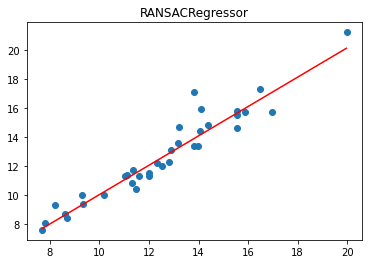

Mean MAE: 0.459 (0.021)


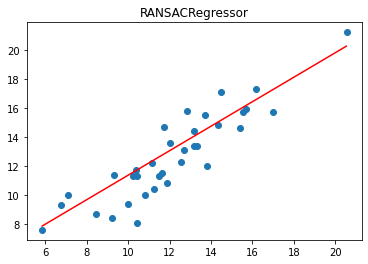

Mean MAE: 0.454 (0.030)


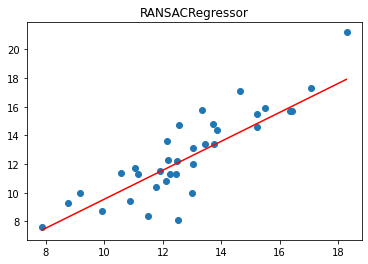

In [142]:

#robust regression using ss
# define the model
model_rr_ss = RANSACRegressor()
# evaluate model
Rresults_ss = evaluate_model(x_train_inter_scaled[ss_sortedFeatures], y_train_scaled, model_rr_parse)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_ss), std(Rresults_ss)))
# plot the line of best fit
Rresults_ss = model_rr_ss.fit(x_train_inter_scaled[ss_sortedFeatures],y_train_scaled)
RFitted_ss = model_rr_ss.predict(x_train_inter_scaled[ss_sortedFeatures])
RFitted_ss_all = model_rr_ss.predict(pd.DataFrame(x_train_inter_scaler.transform(X_inter.loc[all_data.index]),index=all_data.index,columns=x_train_inter_scaled.columns)[ss_sortedFeatures])
y_valid_rr_ss_fitted = model_rr_ss.predict(pd.DataFrame(x_train_inter_scaler.transform(X_inter.loc[X_valid.index]),index=X_valid.index,columns=x_train_inter_scaled.columns)[ss_sortedFeatures])
plot_best_fit(RFitted_ss.reshape(-1, 1)*y_train_scaler.scale_[0] + y_train_scaler.mean_[0],y_train_scaled*y_train_scaler.scale_[0] + y_train_scaler.mean_[0], model_rr_parse)

#robust regression using best
# define the model
model_rr_best = RANSACRegressor()
# evaluate model
Rresults_best = evaluate_model(x_train_inter_scaled[best['features']], y_train_scaled, model_rr_best)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_best), std(Rresults_best)))
# plot the line of best fit
Rresults_best = model_rr_best.fit(x_train_inter_scaled[best['features']],y_train_scaled)
RFitted_best = model_rr_best.predict(x_train_inter_scaled[best['features']])
y_valid_rr_best_fitted = model_rr_best.predict(pd.DataFrame(x_train_inter_scaler.transform(X_inter.loc[X_valid.index]),index=X_valid.index,columns=x_train_inter_scaled.columns)[best['features']])
plot_best_fit(RFitted_best.reshape(-1, 1)*scaler.scale_[0] + scaler.mean_[0],y_train_scaled*y_train_scaler.scale_[0] + y_train_scaler.mean_[0], model_rr_best)

#robust regression using parse
# define the model
model_rr_parse = RANSACRegressor()
# evaluate model
Rresults_parse = evaluate_model(x_train_inter_scaled[parse['features']], y_train_scaled, model_rr_parse)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_parse), std(Rresults_parse)))
# plot the line of best fit
Rresults_parse = model_rr_parse.fit(x_train_inter_scaled[parse['features']],y_train_scaled)
RFitted_parse = model_rr_parse.predict(x_train_inter_scaled[parse['features']])
RFitted_parse_all = model_rr_parse.predict(pd.DataFrame(x_train_inter_scaler.transform(X_inter.loc[all_data.index]),index=all_data.index,columns=x_train_inter_scaled.columns)[parse['features']])
y_valid_rr_parse_fitted = model_rr_parse.predict(pd.DataFrame(x_train_inter_scaler.transform(X_inter.loc[X_valid.index]),index=X_valid.index,columns=x_train_inter_scaled.columns)[parse['features']])
plot_best_fit(RFitted_parse.reshape(-1, 1)*y_train_scaler.scale_[0] + y_train_scaler.mean_[0],y_train_scaled*y_train_scaler.scale_[0] + y_train_scaler.mean_[0], model_rr_parse)

In [130]:
y_valid_ss_fitted = model_ss.predict(pd.DataFrame(x_train_inter_scaler.transform(X_inter.loc[X_valid.index]),index=X_valid.index,columns=x_train_inter_scaled.columns)[ss_sortedFeatures])
y_valid_eb_fitted = model_eb.predict(pd.DataFrame(x_train_inter_scaler.transform(X_inter.loc[X_valid.index]),index=X_valid.index,columns=x_train_inter_scaled.columns)[best['features']])
y_valid_ep_fitted = model_ep.predict(pd.DataFrame(x_train_inter_scaler.transform(X_inter.loc[X_valid.index]),index=X_valid.index,columns=x_train_inter_scaled.columns)[parse['features']])

In [132]:
y_valid_scaled = y_scaler.transform(np.array(y_valid).reshape(-1, 1))

In [133]:
print("OLS SS: " + str(mean(absolute(np.array(y_valid_scaled)-y_valid_ss_fitted))))
print("EN best: " + str(mean(absolute(np.array(y_valid_scaled)-y_valid_eb_fitted))))
print("EN parse: " + str(mean(absolute(np.array(y_valid_scaled)-y_valid_ep_fitted))))

print("RR SS: " + str(mean(absolute(np.array(y_valid_scaled)-y_valid_rr_ss_fitted))))
print("RR best: " + str(mean(absolute(np.array(y_valid_scaled)-y_valid_rr_best_fitted))))
print("RR parse: " + str(mean(absolute(np.array(y_valid_scaled)-y_valid_rr_parse_fitted))))

OLS SS: 0.8324097780094941
EN best: 1.0143831143832995
EN parse: 1.0143831143832995
RR SS: 0.5040445664465946
RR best: 1.0143740571077997
RR parse: 1.042838854911272


In [143]:
print("RR parse: " + str(mean(absolute(np.array(y_scaler.transform(y))-RFitted_parse_all))))
print("RR ss: " + str(mean(absolute(np.array(y_scaler.transform(y))-RFitted_ss_all))))

RR parse: 0.5061484468709706
RR ss: 0.2976084956777306


array([[ 8.02233135e-01],
       [-1.64371634e+00],
       [ 4.67171563e-01],
       [ 1.33833165e+00],
       [-1.91463755e-03],
       [-6.38531624e-01],
       [-1.34216093e+00],
       [-1.10761783e+00],
       [-3.54207948e-02],
       [ 4.67171563e-01],
       [-1.40917324e+00],
       [-2.36457738e-01],
       [-3.70482367e-01],
       [-6.89269520e-02],
       [-6.05025467e-01],
       [-6.72037782e-01],
       [ 1.33833165e+00],
       [ 1.33833165e+00],
       [-3.36976210e-01],
       [-1.74423481e+00],
       [-1.10761783e+00],
       [ 3.66653092e-01],
       [-1.24164245e+00],
       [ 2.64507178e+00],
       [ 3.15915197e-02],
       [ 5.00677721e-01],
       [-8.39568568e-01],
       [-6.72037782e-01],
       [-1.91176560e+00],
       [-1.54319787e+00],
       [ 1.27131934e+00],
       [ 9.86038341e-02],
       [ 4.33665406e-01],
       [-4.37494681e-01],
       [ 3.15915197e-02],
       [ 8.69245450e-01],
       [ 9.86038341e-02],
       [-4.03988524e-01],
       [-5.3